# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif

%matplotlib inline
plt.style.use('seaborn')

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Начнём наше исследование со знакомства с данными.

Данные о клиентах банка:
* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

Прочие признаки:
* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.


In [3]:
df = pd.read_csv('/home/azudilins/Documents/Data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Начнём с того, что оценим, насколько предложенные данные готовы к дальнейшему анализу. В первую очередь давайте выясним, есть ли в данных пропущенные значения (пустые, незаполненные ячейки).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Есть 25 пропущенных значения в признаке 'balance'.

In [5]:
# посмотрим есть ли в признаке job пропущенные значения
# возможно, они обозначены каким-то специальным словом
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

Пропуски закодированы словом 'unknown'.

In [6]:
# преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def repair_balance(balance):
    balance = str(balance)
    balance = balance.replace(' ', '')
    balance = balance.replace(',', '.')
    balance = balance.replace('$', '')
    return float(balance)

df['balance'] = df['balance'].apply(repair_balance)
print(f"Среднее значение по преобразованному в корректный вид признаку 'balance': {round(df['balance'].mean(), 3)}")

Среднее значение по преобразованному в корректный вид признаку 'balance': 1529.129


In [7]:
# обработайте пропуски в признаке balance, заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
print(f"Среднее значение 'balance' после замены пропусков медианным значением: {round(df['balance'].mean(), 3)}")

Среднее значение 'balance' после замены пропусков медианным значением: 1526.936


In [8]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(
    lambda x: df['job'].mode()[0] if x == 'unknown' else x
)
df['education'] = df['education'].apply(
    lambda x: df['education'].mode()[0] if x == 'unknown' else x
)

# cредний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
mask_1 = df['job'] == df['job'].mode()[0]
mask_2 = df['education'] == df['education'].mode()[0]
round(df[mask_1 & mask_2]['balance'].mean(), 3)

1598.883

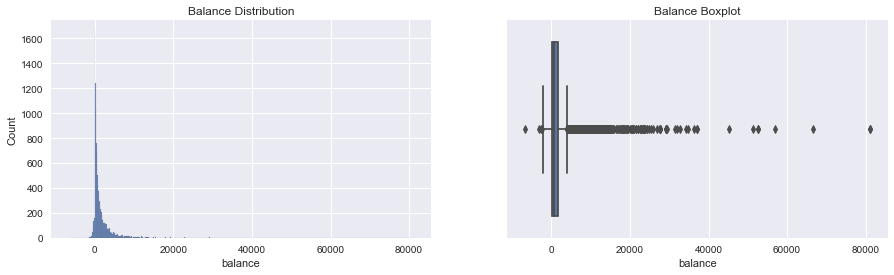

In [9]:
# удалим все выбросы для признака balance
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))
histplot = sns.histplot(data = df, x = 'balance', ax = axes[0])
histplot.set_title('Balance Distribution')
boxplot = sns.boxplot(data = df, x = 'balance', ax = axes[1])
boxplot.set_title('Balance Boxplot');

In [10]:
def outliers_iqr(data, feature, left = 1.5, right = 1.5, log_scale = False):
    """
    Функция для нахождения выбросов по методу Тьюки.
    
    :param data: датафрейм
    :param feature: признак для анализа
    :param left: коэффициент межквартильного размаха для нижней границы
    :param right: коэффициент межквартильного размаха для верхней границы
    :log_scale: True для логнормального распределения признака
    
    :return: Возвращет выбросы и очищенный датафрейм.
    """
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    print(f'Нижняя граница: {round(lower_bound)}')
    print(f'Верхняя граница: {round(upper_bound)}')
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Нижняя граница: -2241
Верхняя граница: 4063
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


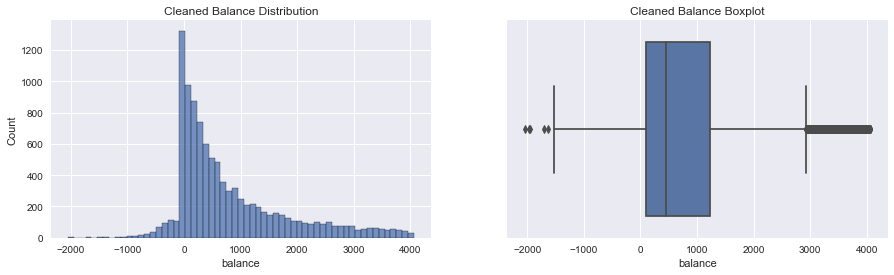

In [11]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))
histplot = sns.histplot(data = cleaned, x = 'balance', ax = axes[0])
histplot.set_title('Cleaned Balance Distribution')
boxplot = sns.boxplot(data = cleaned, x = 'balance', ax = axes[1])
boxplot.set_title('Cleaned Balance Boxplot');

## Часть 2:  Разведывательный анализ

In [12]:
# изучим соотношение классов в ваших данных на предмет несбалансированности
cleaned['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

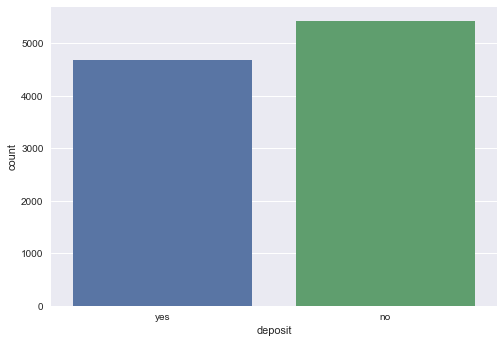

In [13]:
sns.countplot(data = cleaned, x = 'deposit');

Есть небольшая несбалансированность классов. 4681 клиент открыли депозит.

In [14]:
# рассчитаем описательные статистики для количественных переменных
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Максимальный возраст клиента банка - 95 лет. Минимальная продолжительность разговора с клиентом банка - 2 секунды.

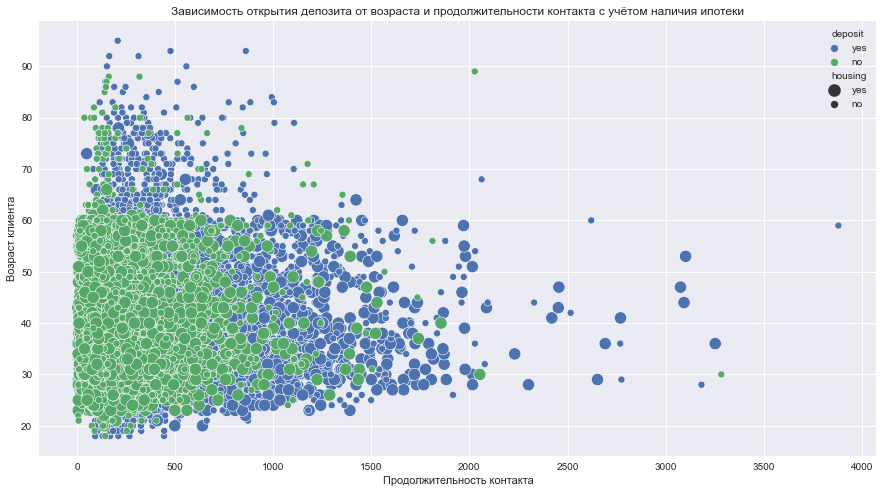

In [15]:
fig = plt.figure(figsize = (15, 8))
scatterplot = sns.scatterplot(
    data = cleaned,
    x = 'duration',
    y = 'age',
    hue = 'deposit',
    size = 'housing',
    sizes = (50, 150)
)
scatterplot.set_title('Зависимость открытия депозита от возраста и продолжительности контакта с учётом наличия ипотеки')
scatterplot.set_xlabel('Продолжительность контакта')
scatterplot.set_ylabel('Возраст клиента');

Большинство людей в возросте до 20 лет и старше 60 открывают депозиты. Эта же категория людей практически не имеет кридитов на жильё. Люди в возрасте от 20 до 60 лет тоже открывают депозиты, но в основном только после продолжительного контакта.

In [16]:
#рассчитаем описательные статистики для категориальных переменных
cleaned.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Среди клиентов банка представлено всего 11 сфер занятости. Маркетинговая компания проходила каждый месяц. Чуть более половины клиентов в браке, а также чуть более половины со среднем образованием.

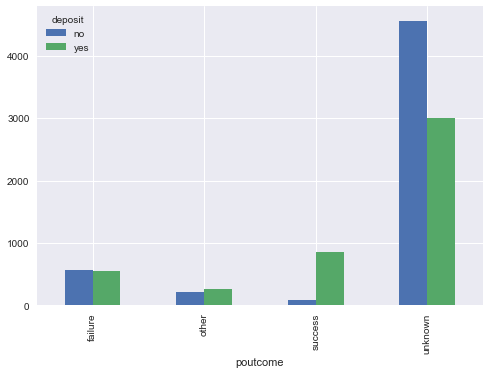

In [17]:
# узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач
types = (
    cleaned
    .groupby('poutcome')['deposit']
    .value_counts()
    .unstack()
)
types.plot(kind = 'bar');

Для значения статуса 'success' предыдущей компании в текущей успехов намного больше, чем неудач.

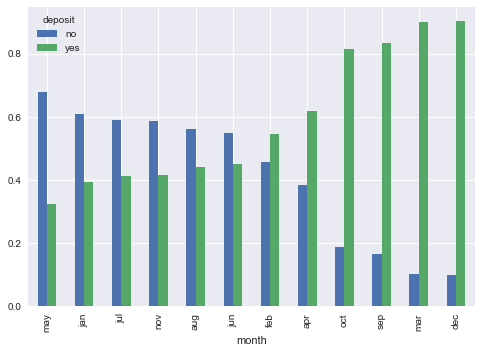

In [18]:
# узнаем, в каком месяце чаще всего отказывались от предложения открыть депозит
months = (
    cleaned
    .groupby('month')['deposit']
    .value_counts(normalize = True)
    .unstack()
    .sort_values(by = 'no', ascending = False)
)
months.plot(kind = 'bar');

В мае самый большой процент неудач при взаимодействии в текущей маркетинговой компании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить.

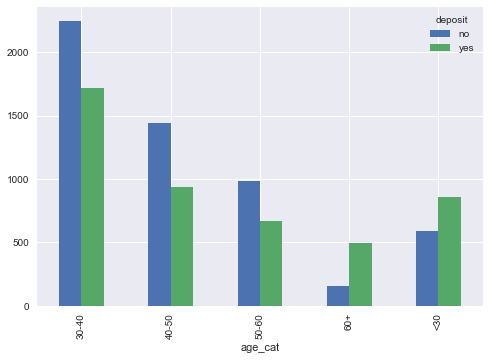

In [19]:
# создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения
def get_age_cat(age):
    """
    Функция для разделения по возрастным группам.    
    :param age: возраст    
    :return: Возвращает возрастную категорию
    """
    if age < 30:
        return '<30'
    elif age >= 30 and age < 40:
        return '30-40'
    elif age >= 40 and age < 50:
        return '40-50'
    elif age >= 50 and age < 60:
        return '50-60'
    else:
        return '60+'


cleaned['age_cat'] = cleaned['age'].apply(get_age_cat)

ages = (
    cleaned
    .groupby('age_cat')['deposit']
    .value_counts()
    .unstack()
)
ages.plot(kind = 'bar');

Возрастные группы '<30' и '60+' более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения.

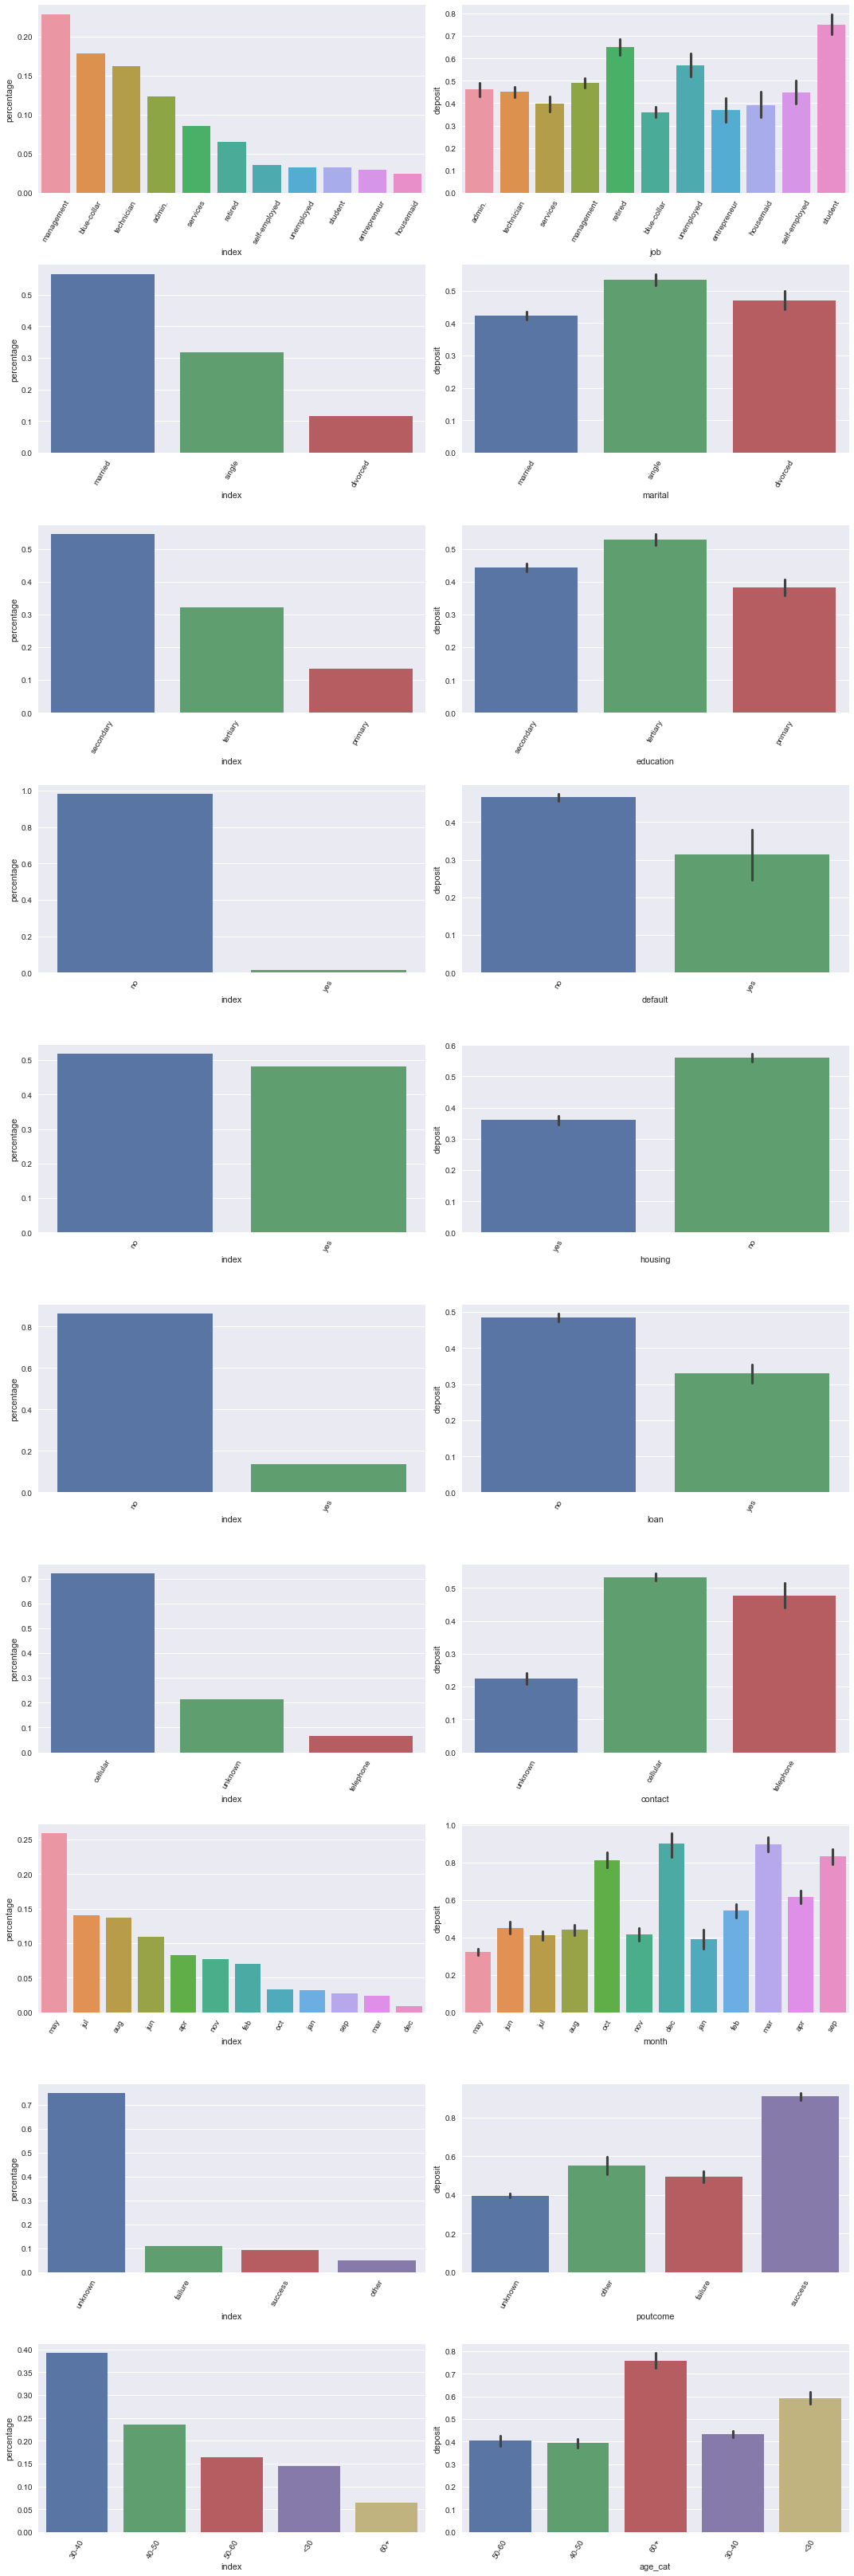

In [20]:
# построим визуализации для категориальных признаков
# для удобства переобозначим целевой признак
data = cleaned.copy()
data['deposit'] = data['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

# исследуем категориальные признаки
types = data.dtypes
cat_features = list(types[types == 'object'].index)

n = len(cat_features) # число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize = (15, 45)) # фигура + n * 2 координатных плоскостей
# создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    # строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (
        data[feature]
        .value_counts(normalize = True)
        .sort_values(ascending = False)
        .rename('percentage')
        .reset_index()
    )
    count_barplot = sns.barplot(
        data = count_data,
        x = 'index',
        y = 'percentage',
        ax = axes[i][0]
    )
    count_barplot.xaxis.set_tick_params(rotation = 60)
    # строим столбчатую диаграмму доли клиентов открывающих депозит (среднее по столбцу deposit) в зависимости от категории
    mean_barplot = sns.barplot(
        data = data,
        x = feature,
        y = 'deposit',
        ax = axes[i][1]
    )
    mean_barplot.xaxis.set_tick_params(rotation = 60)
plt.tight_layout(); # выравнивание графиков

Большая часть людей не имеет просроченный кредит. Среди студентов есть тенденция соглашаться открывать депозит, а среди "синих воротничков" - отказываться. В сфере управления занято наибольшее число клиентов банка. При семейном положении 'не замужем' есть тенденция открывать депозит, а не отказываться от его открытия.

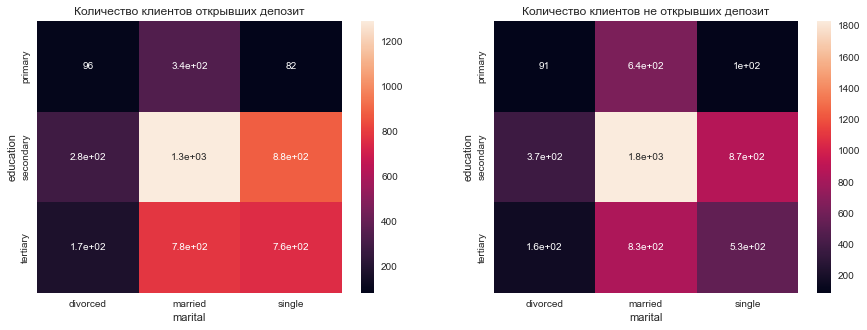

In [21]:
# построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# разделим таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл
deposit_yes = cleaned[cleaned['deposit'] == 'yes'].pivot_table(
    values = 'deposit',
    index = 'education',
    columns = 'marital',
    aggfunc = 'count'
)
deposit_no = cleaned[cleaned['deposit'] == 'no'].pivot_table(
    values = 'deposit',
    index = 'education',
    columns = 'marital',
    aggfunc = 'count'
)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
heatmap_yes = sns.heatmap(deposit_yes, annot = True, ax = axes[0])
heatmap_yes.set_title('Количество клиентов открывших депозит')
heatmap_no = sns.heatmap(deposit_no, annot = True, ax = axes[1])
heatmap_no.set_title('Количество клиентов не открывших депозит');

Самым многочисленным является пресечение категорий secondary и married.

## Часть 3: преобразование данных

Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: education.

Обработаем его с помощью метода LabelEncoder, используя метод без дополнительных настроек.

Ранее мы создали порядковую переменную для возраста. Обработаем её по такому же принципу, чтобы её можно было использовать при обучении модели.

In [22]:
LE = LabelEncoder()
cleaned['education'] = LE.fit_transform(cleaned['education'])
cleaned['age_cat'] = LE.fit_transform(cleaned['age_cat'])

In [23]:
# преобразовываем бинарные переменные в представление из нулей и единиц
binary_columns = ['deposit', 'default', 'housing', 'loan']

for col in binary_columns:
    cleaned[col] = cleaned[col].apply(lambda x: 1 if x == 'yes' else 0)

In [24]:
# создаём дамми-переменные из номинальных переменных
cleaned = pd.get_dummies(cleaned)

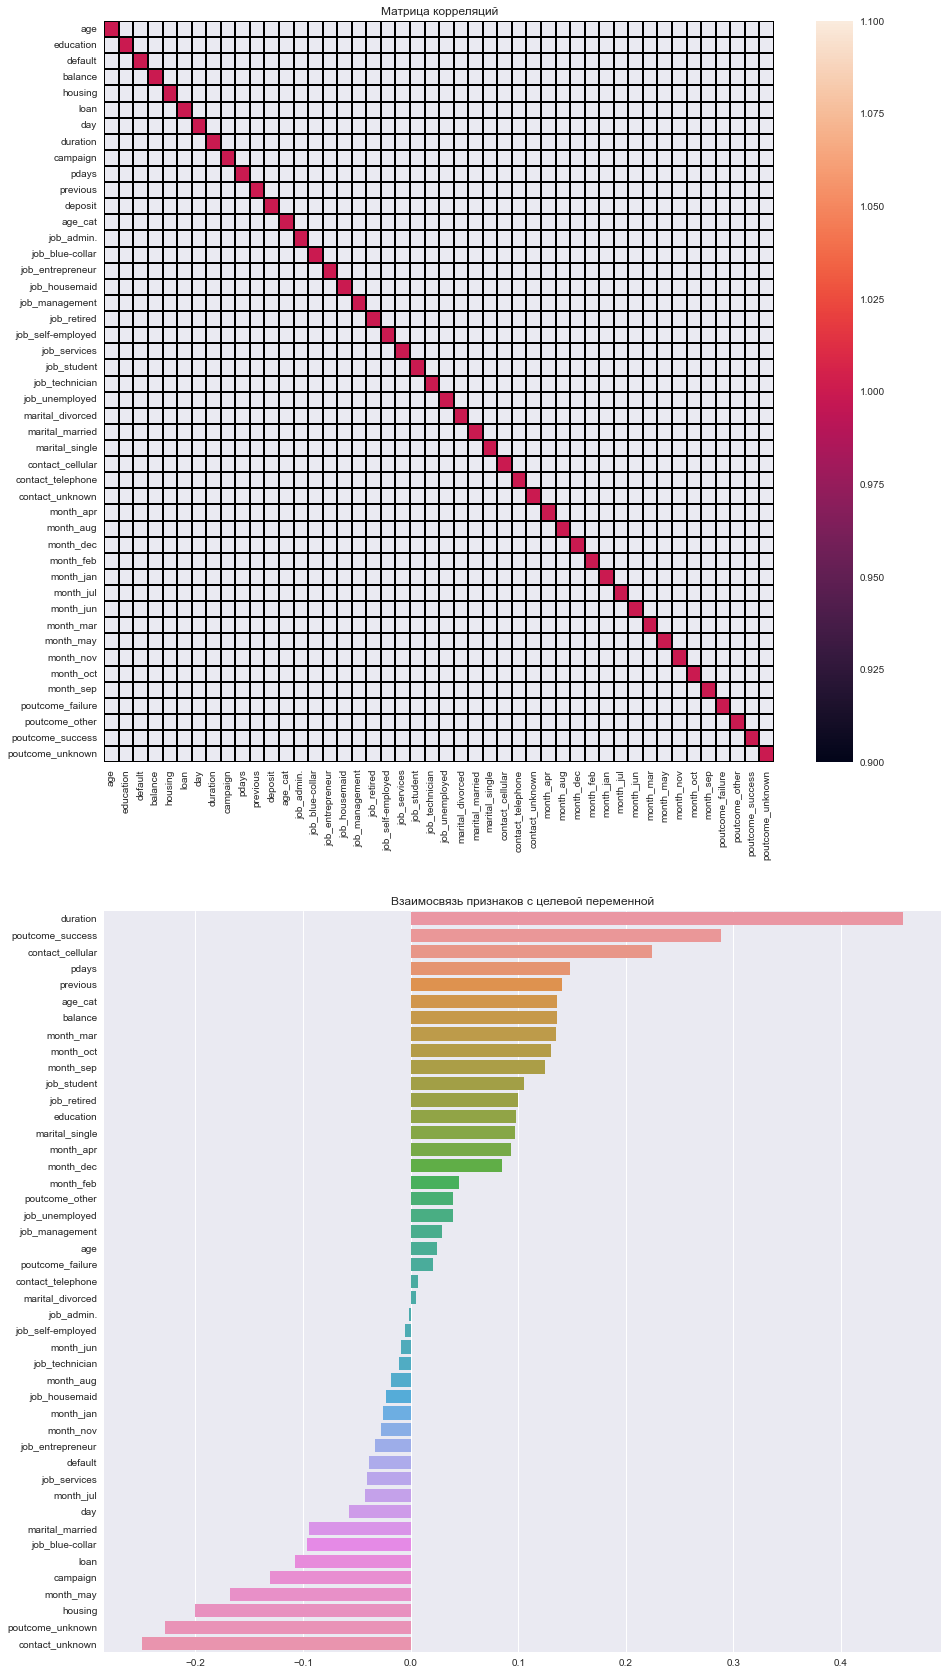

In [25]:
# построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
corr = cleaned.corr()
# выведем только данные с высоким уровнем корреляции
mask_1 = abs(corr) <= -0.9
mask_2 = abs(corr) >= 0.9
corr_data = corr[mask_1 | mask_2]

corr_with_deposit = (
    cleaned
    .drop('deposit', axis = 1)
    .corrwith(cleaned['deposit'])
    .sort_values(ascending = False)
)

fig, axes = plt.subplots(2, 1, figsize = (15, 30))

heatmap = sns.heatmap(
    data = corr_data,
    linewidth = 0.3,
    linecolor = 'black',
    ax = axes[0]
)
heatmap.set_title('Матрица корреляций')

barplot = sns.barplot(
    x = corr_with_deposit,
    y = corr_with_deposit.index
)
barplot.set_title('Взаимосвязь признаков с целевой переменной');

Теперь нам необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

При разбиении зададим параметр random_state = 42, а размер тестовой выборки возьмём за 0.33. Не забудем добавить аргумент, определяющий сохранение соотношений целевого признака.

In [26]:
X = cleaned.drop(['deposit'], axis = 1)
y = cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print(f'Train size: {X_train.shape}')
print(f'Test size: {X_test.shape}')

Train size: (6770, 45)
Test size: (3335, 45)


In [27]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k = 15)
selector.fit(X_train, y_train)

X_train = X_train[selector.get_feature_names_out()]
X_test = X_test[selector.get_feature_names_out()]

In [30]:
# нормализуем данные с помощью minmaxscaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Для начала реализуем самый простой алгоритм, который вам известен — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

Оценим качество модели на тестовой выборке.

In [32]:
# создаём объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver = 'sag',
    random_state = 42,
    max_iter = 1000
)
# обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(log_reg.score(X_test_scaled, y_test)))

accuracy на тестовом наборе: 0.80


Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм — решающие деревья. В качестве параметров для начала возьмём следующие:

   * criterion = 'entropy';
   * random_state = 42.

Остальные параметры оставим по умолчанию.


In [33]:
# создаём объект класса дерево решений
tree_reg = tree.DecisionTreeClassifier(
    criterion = 'entropy',
    random_state = 42
)
# обучаем дерево по алгоритму CART
tree_reg.fit(X_train_scaled, y_train)
# выводим значения метрик
print('accuracy на тренеровочном наборе: {:.2f}'.format(tree_reg.score(X_train_scaled, y_train)))
print('accuracy на тестовом наборе: {:.2f}'.format(tree_reg.score(X_test_scaled, y_test)))

accuracy на тренеровочном наборе: 1.00
accuracy на тестовом наборе: 0.75


После реализации алгоритма и оценки его качества можно наблюдать переобучение. Переберём различные максимальные глубины деревьев и найдём глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

In [34]:
# посмотрим получившуюся глубину
tree_reg.get_depth()

36

Максимальное accuracy на тестовой выборке: 0.82


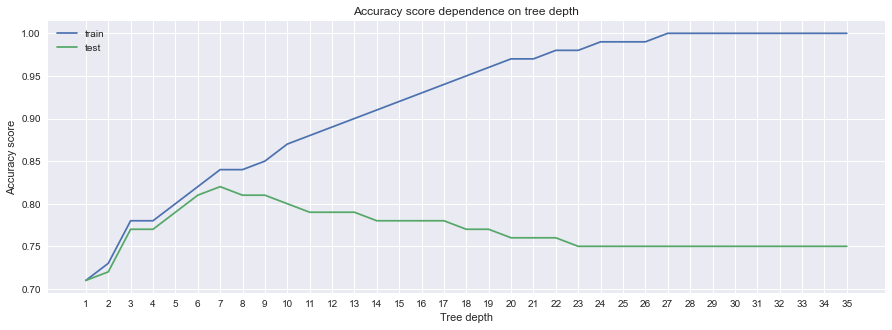

In [35]:
tree_depths = list(range(1, 36))
train_accuracy = []
test_accuracy = []

# перебираем глубины и сохраняем значения
for depth in tree_depths:
    tree_reg = tree.DecisionTreeClassifier(
        criterion = 'entropy',
        random_state = 42,
        max_depth = depth
    )
    tree_reg.fit(X_train_scaled, y_train)
    train_accuracy.append(round(tree_reg.score(X_train_scaled, y_train),2 ))
    test_accuracy.append(round(tree_reg.score(X_test_scaled, y_test), 2))

# визуализируем метрики при различных глубинах
fig, ax = plt.subplots(figsize = (15, 5)) # фигура + координатная плоскость
# строим линейный график зависимости train_accuracy от глубины дерева
ax.plot(tree_depths, train_accuracy, label = 'train')
# строим линейный график зависимости test_accuracy от глубины дерева
ax.plot(tree_depths, test_accuracy, label = 'test')

# даём графику название и подписываем оси
ax.set_title('Accuracy score dependence on tree depth')
ax.set_xlabel('Tree depth')
ax.set_ylabel('Accuracy score')
# устанавливаем метки по оси x
ax.set_xticks(tree_depths)
# отображаем легенду
ax.legend();

print(f'Максимальное accuracy на тестовой выборке: {max(test_accuracy)}')

Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

Реализуем оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:

   * 'min_samples_split': [2, 5, 7, 10];
   * 'max_depth':[3,5,7].

In [36]:
# подберём оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {
    'min_samples_split': [2, 5, 7, 10], # минимальное количество объектов в листе
    'max_depth':[3,5,7] # максимальная глубина дерева
}
grid_search = GridSearchCV(
    estimator = tree.DecisionTreeClassifier(
        criterion = 'entropy',
        random_state = 42
    ),
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1
)
grid_search.fit(X_train_scaled, y_train)

y_test_pred = grid_search.predict(X_test_scaled)
print(f'Наилучшая комбинация параметров: {grid_search.best_params_}')
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшая комбинация параметров: {'max_depth': 7, 'min_samples_split': 10}
f1_score на тестовом наборе: 0.81


## Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Мы уже смогли обучить несложные модели, и теперь пришло время усложнить их, а также посмотреть, улучшится ли результат (если да, то насколько). Мы обучили решающие деревья, и теперь пришла пора объединить их в случайный лес.

Обучим случайный лес со следующими параметрами:

   * n_estimators = 100;
   * criterion = 'gini';
   * min_samples_leaf = 5;
   * max_depth = 10;
   * random_state = 42.

In [37]:
# создаём объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

# обучаем модель
rf.fit(X_train_scaled, y_train)
# выводим значения метрик
y_test_pred = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Дата-сайентист не должен останавливаться на одной модели — он должен пробовать все доступные варианты. Поэтому теперь попробуем сравнить полученные результаты с моделью градиентного бустинга. Используем градиентный бустинг для решения задачи классификации, задав для него следующие параметры:

   * learning_rate = 0.05;
   * n_estimators = 300;
   * min_samples_leaf = 5;
   * max_depth = 5;
   * random_state = 42.

In [38]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05, # темп обучения
    n_estimators = 500, # число деревьев
    min_samples_leaf = 5, # минимальное число объектов в листе
    max_depth = 5, # максимальная глубина дерева
    random_state = 42 # генератор случайных чисел
)
gb.fit(X_train_scaled, y_train)

y_test_pred = gb.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Мы уже попробовали построить разные модели, и теперь пришло время построить ансамбль из моделей разного типа.

Используем стекинг, объединив те алгоритмы, которые мы уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используем модель логистической регрессии.

Параметры оставим те же, что были в наших алгоритмах в предыдущих заданиях.

In [39]:
# создаём список кортежей вида ('наименование модели', модель)
estimators = [
    (
        'dt', tree.DecisionTreeClassifier(
            criterion = 'entropy',
            random_state = 42,
            max_depth = 7,
            min_samples_leaf = 10
        )
    ),
    (
        'lr', linear_model.LogisticRegression(
            solver = 'sag',
            random_state = 42,
            max_iter = 1000
        )
    ),
    (
        'gb', ensemble.GradientBoostingClassifier(
            learning_rate = 0.05,
            n_estimators = 500,
            min_samples_leaf = 5,
            max_depth = 5,
            random_state = 42
        )
    )
]

# создаём объект класса стекинг
sc = ensemble.StackingClassifier(
    estimators = estimators,
    final_estimator = linear_model.LogisticRegression(random_state = 42)
)
# обучаем модель
sc.fit(X_train_scaled, y_train)

y_test_pred = sc.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, выберем три признака, дающих наибольший вклад.

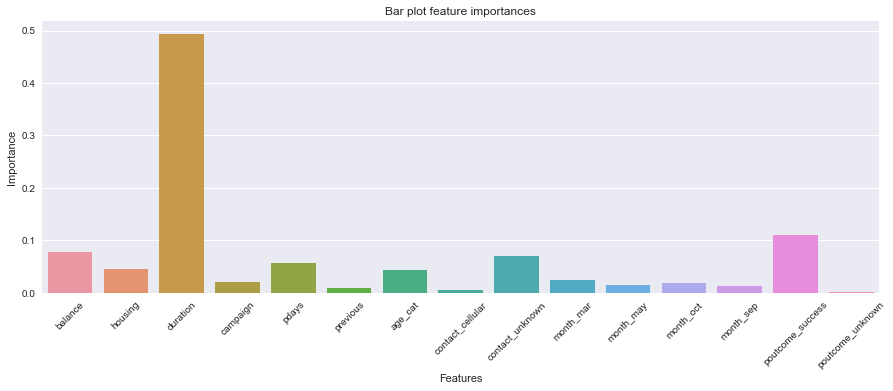

In [40]:
# оценим, какие признаки демонстрируют наибольшую важность в модели градиентного бустинга
fig, ax = plt.subplots(figsize = (15, 5)) # фигура + координатная плоскость
feature = X_train.columns
feature_importances = gb.feature_importances_ # важность признаков
# строим столбчатую диаграмму
sns.barplot(x = feature, y = feature_importances, ax = ax)
# добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.xaxis.set_tick_params(rotation = 45);

Наибольшую важность имеют признаки:

   * 'duration'. Продолжительность контакта - индикатор заинтересованности клиента.
   * 'poutcome_success'. Однажды согласившиеся клиенты более склонны согласиться снова.
   * 'balance'. Чем больше денег, тем больше вероятность, что есть 'свободные' деньги, которые можно вложить.

Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearch. Однако, это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. Применим его для оптимизации гиперпараметров. Для перебора возьмём случайный лес и следующие параметры:

   * n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
   * max_depth = trial.suggest_int('max_depth', 10, 30, 1);
   * min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

In [41]:
# реализуем оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
    # задаём пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # создаём модель
    model = ensemble.RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_leaf = min_samples_leaf,
        random_state = 42
    )
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = cross_val_score(
        estimator = model,
        X = X_train,
        y = y_train,
        cv = 5,
        scoring = 'f1',
        n_jobs = -1
    ).mean()
    
    return score


# создаём объект исследования
# можем напрямую указать, что нам необходимо оптимизировать метрику direction = 'maximize'
study = optuna.create_study(
    study_name = 'RandomForestClassifier',
    direction = 'maximize'
)
# ищем наилучшую комбинацию n_trials раз
study.optimize(optuna_rf, n_trials = 20)

# выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров: {}'.format(study.best_params))
print('F1_score на обучающем наборе: {:.2f}'.format(study.best_value))

# рассчитаем метрики для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state = 42)
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

[I 2023-01-20 16:46:46,353] A new study created in memory with name: RandomForestClassifier
[I 2023-01-20 16:47:06,460] Trial 0 finished with value: 0.8195785590776895 and parameters: {'n_estimators': 194, 'max_depth': 19, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8195785590776895.
[I 2023-01-20 16:47:20,616] Trial 1 finished with value: 0.8268651105915579 and parameters: {'n_estimators': 156, 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8268651105915579.
[I 2023-01-20 16:47:29,634] Trial 2 finished with value: 0.8241271775539738 and parameters: {'n_estimators': 125, 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8268651105915579.
[I 2023-01-20 16:47:39,222] Trial 3 finished with value: 0.8192015844182319 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8268651105915579.
[I 2023-01-20 16:47:52,168] Trial 4 finished with value: 0.8253683603207737 and parameters: {'n_

Наилучшие значения гиперпараметров: {'n_estimators': 157, 'max_depth': 13, 'min_samples_leaf': 3}
F1_score на обучающем наборе: 0.83
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335

